# Electrode recording
How to insert electrodes to measure different spiking and extracellular signals from a Brian network simulation.

Imports:

In [1]:
%load_ext autoreload
%autoreload 2

from brian2 import *  # includes numpy
import cleosim
from cleosim import *
# the default cython compilation target isn't worth it for 
# this trivial example
prefs.codegen.target = "numpy"
np.random.seed(1919)

## Network setup
First we create a toy E-I network with Poisson firing rates and assign coordinates:

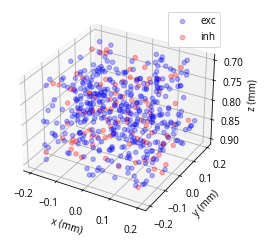

In [2]:
N = 500
n_e = int(N * 0.8)
n_i = int(N * 0.2)

exc = PoissonGroup(n_e, 10 * Hz, name="exc")
inh = PoissonGroup(n_i, 30 * Hz, name="inh")

net = Network([exc, inh])
sim = CLSimulator(net)

cleosim.coordinates.assign_coords_rand_rect_prism(
    exc, xlim=(-0.2, 0.2), ylim=(-0.2, 0.2), zlim=(0.7, 0.9)
)
cleosim.coordinates.assign_coords_rand_rect_prism(
    inh, xlim=(-0.2, 0.2), ylim=(-0.2, 0.2), zlim=(0.7, 0.9)
)
cleosim.coordinates.plot_neuron_positions(exc, inh, colors=["blue", "red"])

## Specifying electrode coordinates

Now we insert an electrode shank probe in the center of the population by injecting an `Probe` device.
Note that `Probe` takes arbitrary coordinates as arguments, so you can place contacts wherever you wish. However, the `cleosim.electrodes` module provides convenience functions to easily generate coordinates [common in NeuroNexus probes](https://www.neuronexus.com/products/electrode-arrays/up-to-15-mm-depth#:~:text=probes%20connect%20seamlessly.-,Site%20Layout%3A,-Below%20are%20examples). Here are some examples:


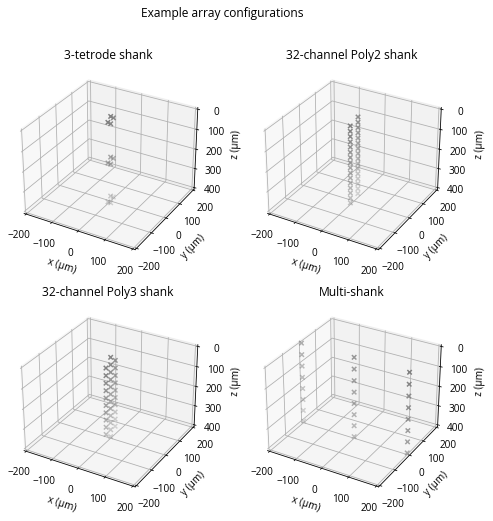

In [3]:
from cleosim import electrodes as elec
from mpl_toolkits.mplot3d import Axes3D

array_length = 0.4 * mm  # length of the array itself, not the shank
tetr_coords = elec.tetrode_shank_coords(array_length, tetrode_count=3)
poly2_coords = elec.poly2_shank_coords(
    array_length, channel_count=32, intercol_space=50 * umeter
)
poly3_coords = elec.poly3_shank_coords(
    array_length, channel_count=32, intercol_space=30 * umeter
)
# by default start_location (location of first contact) is at (0, 0, 0)
single_shank = elec.linear_shank_coords(
    array_length, channel_count=8, start_location=(-0.2, 0, 0) * mm
)
# tile vector determines length and direction of tiling (repeating)
multishank = elec.tile_coords(single_shank, num_tiles=3, tile_vector=(0.4, 0, 0) * mm)

fig = plt.figure(figsize=(8, 8))
fig.suptitle("Example array configurations")
for i, (coords, title) in enumerate(
    [
        (tetr_coords, "3-tetrode shank"),
        (poly2_coords, "32-channel Poly2 shank"),
        (poly3_coords, "32-channel Poly3 shank"),
        (multishank, "Multi-shank"),
    ],
    start=1,
):
    ax = fig.add_subplot(2, 2, i, projection="3d")
    x, y, z = coords.T / umeter
    ax.scatter(x, y, z, marker="x", c="gray")
    ax.set(
        title=title,
        xlabel="x (μm)",
        ylabel="y (μm)",
        zlabel="z (μm)",
        xlim=(-200, 200),
        ylim=(-200, 200),
        zlim=(400, 0),
    )

As seen above, the `tile_coords` function can be used to repeat a single shank to produce coordinates for a multi-shank probe. Likewise it can be used to repeat multi-shank coordinates to achieve a 3D recording array (what NeuroNexus calls a [MatrixArray](https://www.neuronexus.com/products/electrode-arrays/3D-probes)).

For our example we will use a simple linear array. We configure the probe so it has 32 contacts ranging from 0.2 to 1.2 mm in depth. We could specify the orientation, but by default shank coordinates extend downwards (in the positive z direction).

We can add the electrode to the plotting function to visualize it along with the neurons:

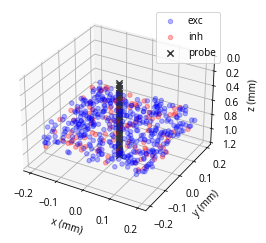

In [4]:
coords = elec.linear_shank_coords(1 * mm, 32, start_location=(0, 0, 0.2) * mm)
probe = elec.Probe("probe", coords)
cleosim.coordinates.plot_neuron_positions(
    exc, inh, colors=["b", "r"], zlim=(0, 1.2), devices_to_plot=[probe]
)

## Specifying signals to record

This looks right, but we need to specify what signals we want to pick up with our electrode.
Let's try the two basic spiking signals and an LFP approximation for point neurons.

The two spiking signals (sorted and multi-unit) take the same parameters, mainly `perfect_detection_radius`, within which all spikes will be detected, and `half_detection_radius`, at which distance a spike has only a 50% chance of being detected. My choice to set these parameters at 50 and 100 μm is arbitary, though from [at least some published data](https://www.frontiersin.org/articles/10.3389/fnins.2019.00385/full#F4) that seems reasonable.

We use default parameters for the Teleńczuk kernel LFP approximation method (TKLFP), but will need to specify cell type (excitatory or inhibitory) and sampling period (if unavailable from a connected IO processor) upon injection.

In [5]:
mua = elec.MultiUnitSpiking(
    "mua",
    perfect_detection_radius=0.05 * mm,
    half_detection_radius=0.1 * mm,
    save_history=True,
)
ss = elec.SortedSpiking("ss", 0.05 * mm, 0.1 * mm, save_history=True)
tklfp = elec.TKLFPSignal("tklfp", save_history=True)

probe.add_signals(mua, ss, tklfp)

from cleosim.processing import RecordOnlyProcessor
sim.set_io_processor(RecordOnlyProcessor(sample_period_ms=1))
sim.inject_recorder(probe, exc, tklfp_type="exc")
sim.inject_recorder(probe, inh, tklfp_type="inh")

## Simulation and results

Now we'll run the simulation:

In [6]:
sim.run(150*ms)

And plot the output of the three signals we've recorded:

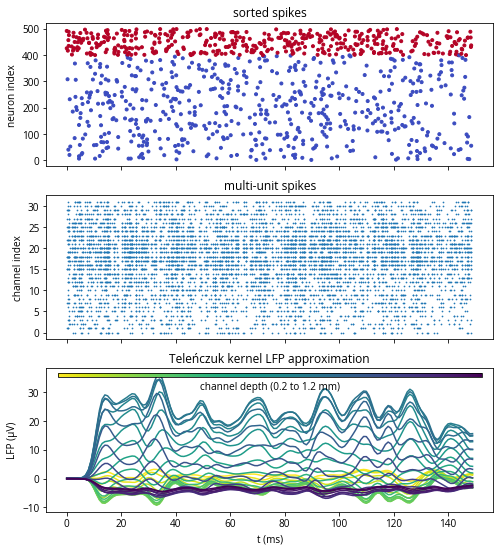

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

axs[0].scatter(ss.t_ms, ss.i, marker=".", c=ss.i >= n_e, cmap="coolwarm")
axs[0].set(title="sorted spikes", ylabel="neuron index")

axs[1].scatter(mua.t_ms, mua.i, marker=".", s=2)
axs[1].set(title="multi-unit spikes", ylabel="channel index")

lines = axs[2].plot(tklfp.lfp_uV)
axs[2].set(
    title="Teleńczuk kernel LFP approximation", xlabel="t (ms)", ylabel="LFP (μV)"
)

# color-code channel depth
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(axs[2], width='95%', height='3%', loc="upper center")
for i in range(32):
    l = lines[i]
    l.set_color(plt.cm.viridis_r(i / 31))
from matplotlib.colors import Normalize
channel_mappable = plt.cm.ScalarMappable(Normalize(0, 1.2), plt.cm.viridis_r)
fig.colorbar(
    channel_mappable,
    cax=axins,
    orientation="horizontal",
    ticks=[],
    label="channel depth (0.2 to 1.2 mm)",
);

Or, to see the LFP as a function of depth better:

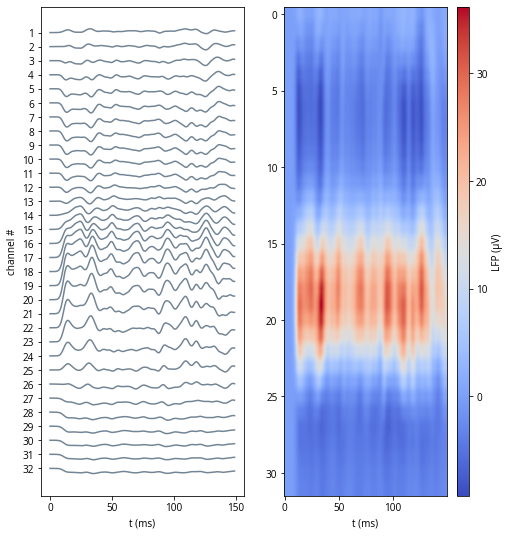

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(8, 9))
channel_offsets = -12 * np.arange(32)
lfp_to_plot = tklfp.lfp_uV + channel_offsets
axs[0].plot(lfp_to_plot, color="xkcd:steel")
axs[0].set(
    yticks=channel_offsets,
    yticklabels=range(1, 33),
    xlabel="t (ms)",
    ylabel="channel #",
);
im = axs[1].imshow(tklfp.lfp_uV.T, aspect='auto', cmap='coolwarm')
axs[1].set(xlabel='t (ms)')
fig.colorbar(im, aspect=40, label='LFP (μV)');
